In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [17]:
weatherAUS = pd.read_csv('weatherAUS.csv')
len(weatherAUS)

145460

NaN dans Temp9am: 1767
NaN dans Temp3pm: 3609
NaN dans la colonne de sortie: 1129
NaN dans Humidity9am: 2654
NaN dans Humidity3pm: 4507
NaN dans la colonne de sortie: 1887
NaN dans WindSpeed9am: 1767
NaN dans WindSpeed3pm: 3062
NaN dans la colonne de sortie: 1213
NaN dans Pressure9am: 15065
NaN dans Pressure3pm: 15028
NaN dans la colonne de sortie: 14804


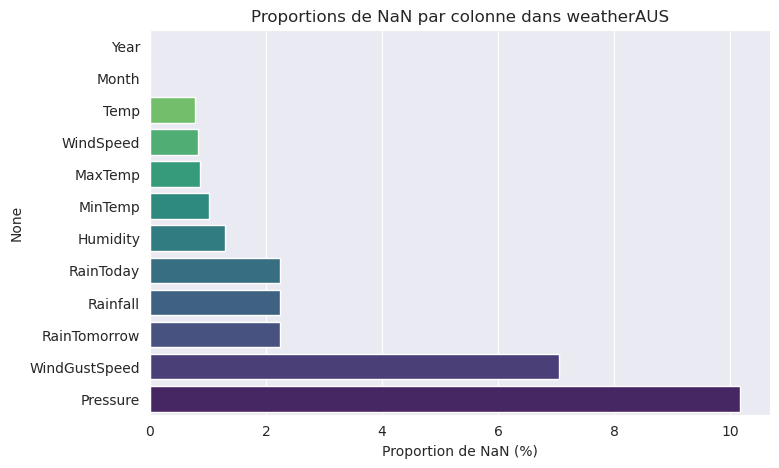

In [18]:
def combine_values(df, column1, column2, verbose=False):
    result = pd.Series(index=df.index)

    for i, row in df.iterrows():
        if pd.isna(row[column1]) and pd.isna(row[column2]):
            result[i] = np.nan
        elif pd.isna(row[column1]):
            result[i] = row[column2]
        elif pd.isna(row[column2]):
            result[i] = row[column1]
        else:
            result[i] = (row[column1] + row[column2]) / 2
    if verbose:
        # Afficher le nombre de NaN dans les colonnes d'entrée et la colonne de sortie
        num_nan_input1 = df[column1].isna().sum()
        num_nan_input2 = df[column2].isna().sum()
        num_nan_output = result.isna().sum()
        print(f"NaN dans {column1}: {num_nan_input1}")
        print(f"NaN dans {column2}: {num_nan_input2}")
        print(f"NaN dans la colonne de sortie: {num_nan_output}")

    return result

def display_nan_proportion(dataframe: pd.DataFrame, dataframe_name: str = "le dataframe"):
    nan_proportions = (dataframe.isna().sum() / len(dataframe)) * 100
    nan_proportions = nan_proportions.sort_values(ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(x=nan_proportions.values, y=nan_proportions.index, hue=nan_proportions.index, palette='viridis', legend=False)
    plt.xlabel('Proportion de NaN (%)')
    plt.title(f'Proportions de NaN par colonne dans {dataframe_name}')
    plt.gca().invert_yaxis()  # La colonne avec le plus de NaN en bas
    plt.show()

weatherAUS['Temp'] = combine_values(weatherAUS, column1='Temp9am', column2='Temp3pm', verbose=True)
weatherAUS['Humidity'] = combine_values(weatherAUS, column1='Humidity9am', column2='Humidity3pm', verbose=True)
weatherAUS['WindSpeed'] = combine_values(weatherAUS, column1='WindSpeed9am', column2='WindSpeed3pm', verbose=True)
weatherAUS['Pressure'] = combine_values(weatherAUS, column1='Pressure9am', column2='Pressure3pm', verbose=True)

weatherAUS['Date'] = pd.to_datetime(weatherAUS['Date'])
weatherAUS['Month'] = weatherAUS['Date'].dt.month
weatherAUS['Year'] = weatherAUS['Date'].dt.year

columns_to_keep = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'Humidity', 'WindSpeed', 'Pressure', 'Month', 'Temp', 'RainToday', 'Year', 'RainTomorrow']

weatherAUS = weatherAUS[columns_to_keep]

display_nan_proportion(dataframe=weatherAUS, dataframe_name="weatherAUS")

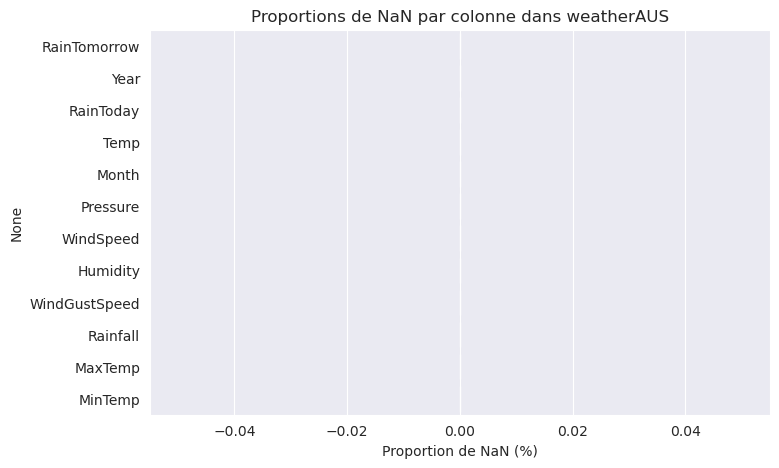

In [19]:
weatherAUS.dropna(inplace=True)
display_nan_proportion(dataframe=weatherAUS, dataframe_name="weatherAUS")

In [20]:
len(weatherAUS)

120960

In [21]:
weatherAUS['RainTomorrow'] = weatherAUS['RainTomorrow'].map({'Yes': 1, 'No': 0})
weatherAUS['RainToday'] = weatherAUS['RainToday'].map({'Yes': 1, 'No': 0})
weatherAUS

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,Humidity,WindSpeed,Pressure,Month,Temp,RainToday,Year,RainTomorrow
0,13.4,22.9,0.6,44.0,46.5,22.0,1007.40,12,19.35,0,2008,0
1,7.4,25.1,0.0,44.0,34.5,13.0,1009.20,12,20.75,0,2008,0
2,12.9,25.7,0.0,46.0,34.0,22.5,1008.15,12,22.10,0,2008,0
3,9.2,28.0,0.0,24.0,30.5,10.0,1015.20,12,22.30,0,2008,0
4,17.5,32.3,1.0,41.0,57.5,13.5,1008.40,12,23.75,0,2008,0
...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,31.0,43.0,14.0,1022.95,6,15.15,0,2017,0
145455,2.8,23.4,0.0,31.0,37.5,12.0,1022.45,6,16.25,0,2017,0
145456,3.6,25.3,0.0,22.0,38.5,11.0,1021.30,6,17.70,0,2017,0
145457,5.4,26.9,0.0,37.0,38.5,9.0,1018.90,6,19.30,0,2017,0


In [22]:
X = weatherAUS.drop(['RainTomorrow'], axis=1)
y = weatherAUS['RainTomorrow']

In [23]:
from imblearn.over_sampling import SMOTE

def apply_smote(X, y, sampling_strategy='auto', random_state=None):
    """
    Applique la technique SMOTE (Synthetic Minority Over-sampling Technique) à un jeu de données déséquilibré.
    
    Args:
        X (array-like): Les caractéristiques du jeu de données.
        y (array-like): Les étiquettes de classe du jeu de données.
        sampling_strategy (str, float, dict or callable): Stratégie de suréchantillonnage. Par défaut, 'auto' est utilisé.
        random_state (int, RandomState instance or None, optional): Contrôle la reproductibilité des échantillons aléatoires.
    
    Returns:
        X_resampled (array-like): Les caractéristiques du jeu de données suréchantillonné.
        y_resampled (array-like): Les étiquettes de classe du jeu de données suréchantillonné.
    """
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    return X_resampled, y_resampled

In [24]:
X_resampled, y_resampled = apply_smote(X, y)


In [25]:
len(X), len(y), len(X_resampled), len(y_resampled)

(120960, 120960, 188956, 188956)

In [26]:
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l1, l2

In [27]:
# Diviser X et y en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Diviser X_train et y_train en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [28]:
len(X_train), len(y_train), len(X_test), len(y_test), len(X_val), len(y_val)

(120931, 120931, 37792, 37792, 30233, 30233)

## Pipeline

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.callbacks import ModelCheckpoint

In [30]:
# Définition du nom du fichier pour enregistrer le meilleur modèle
checkpoint_filepath = 'best_model_in_deep_learning.h5'

# Définition du callback ModelCheckpoint pour sauvegarder le meilleur modèle basé sur la précision de validation
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Définition des rappels ReduceLROnPlateau et EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Création du modèle
def create_model(learning_rate=0.001, dropout_rate=0.4, kernel_regularizer=None, activation='relu'):
    model = Sequential()
    model.add(Dense(128, activation=activation, input_dim=X_train.shape[1], kernel_regularizer=kernel_regularizer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(128, activation=activation, kernel_regularizer=kernel_regularizer))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilation du modèle avec la précision comme métrique supplémentaire
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

# Création du pipeline avec un prétraitement pour la mise à l'échelle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KerasClassifier(build_fn=create_model, verbose=0))
])

# Définition des valeurs à expérimenter pour le taux d'apprentissage initial, le taux de dropout, la régularisation L2 et l'activation
param_grid = {
    'model__learning_rate': [0.001, 0.01, 0.1],
    'model__dropout_rate': [0.3, 0.4, 0.5],
    'model__kernel_regularizer': [None, tf.keras.regularizers.l2(0.01)],
    'model__activation': ['relu', 'sigmoid', 'tanh'],
    'model__batch_size': [16, 32, 64]  # Ajout du batch size
}

# Recherche sur la grille des hyperparamètres avec validation croisée
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, verbose=2)

# Entraînement du modèle avec le callback ModelCheckpoint et des données de validation
history = grid_search.fit(X_train, y_train, model__callbacks=[model_checkpoint, reduce_lr, early_stopping], model__validation_data=(X_val, y_val), model__epochs=100)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres trouvés :", grid_search.best_params_)

# Évaluation du modèle sur les données de test
y_pred = grid_search.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Précision sur les données de test :", accuracy)

/tmp/ipykernel_1177005/1841302960.py:37: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('model', KerasClassifier(build_fn=create_model, verbose=0))
2024-02-15 20:26:29.812476: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-15 20:26:29.813234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-15 20:26:29.813431: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successfu

Fitting 5 folds for each of 162 candidates, totalling 810 fits


2024-02-15 20:26:30.555879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-15 20:26:30.576426: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f0d0c686010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-15 20:26:30.576454: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
2024-02-15 20:26:30.580147: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-15 20:26:30.638162: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-15 20:26:30.657892: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most on


Epoch 1: val_accuracy improved from -inf to 0.50666, saving model to best_model_in_deep_learning.h5

Epoch 2: val_accuracy did not improve from 0.50666

Epoch 3: val_accuracy did not improve from 0.50666

Epoch 4: val_accuracy did not improve from 0.50666

Epoch 5: val_accuracy did not improve from 0.50666

Epoch 6: val_accuracy did not improve from 0.50666

Epoch 7: val_accuracy did not improve from 0.50666
[CV] END model__activation=relu, model__batch_size=16, model__dropout_rate=0.3, model__kernel_regularizer=None, model__learning_rate=0.001; total time= 2.2min

Epoch 1: val_accuracy did not improve from 0.50666

Epoch 2: val_accuracy did not improve from 0.50666

Epoch 3: val_accuracy did not improve from 0.50666

Epoch 4: val_accuracy did not improve from 0.50666

Epoch 5: val_accuracy did not improve from 0.50666

Epoch 6: val_accuracy did not improve from 0.50666
[CV] END model__activation=relu, model__batch_size=16, model__dropout_rate=0.3, model__kernel_regularizer=None, mode

In [31]:
grid_search.best_score_

0.7868949890136718

In [32]:
from sklearn.metrics import classification_report
print("Rapport de classification :")
print(classification_report(y_test, y_pred))

Rapport de classification :
              precision    recall  f1-score   support

           0       0.81      0.76      0.78     18958
           1       0.77      0.82      0.79     18834

    accuracy                           0.79     37792
   macro avg       0.79      0.79      0.79     37792
weighted avg       0.79      0.79      0.79     37792


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f0e19762820>)]),
             param_grid={'model__activation': ['relu', 'sigmoid', 'tanh'],
                         'model__batch_size': [16, 32, 64],
                         'model__dropout_rate': [0.3, 0.4, 0.5],
                         'model__kernel_regularizer': [None,
                         'model__learning_rate': [0.001, 0.01, 0.1]},
             verbose=2)


{'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate': 0.3, 'model__kernel_regularizer': None, 'model__learning_rate': 0.001} 0.7868949890136718
{'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate': 0.3, 'model__kernel_regularizer': None, 'model__learning_rate': 0.01} 0.7794775843620301
{'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate': 0.3, 'model__kernel_regularizer': None, 'model__learning_rate': 0.1} 0.5005498945713043
{'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate': 0.3, 'model__kernel_regularizer': <keras.regularizers.L2 object at 0x7f0e19762520>, 'model__learning_rate': 0.001} 0.777228319644928
{'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate': 0.3, 'model__kernel_regularizer': <keras.regularizers.L2 object at 0x7f0e19762520>, 'model__learning_rate': 0.01} 0.7628648042678833
{'model__activation': 'relu', 'model__batch_size': 16, 'model__dropout_rate':

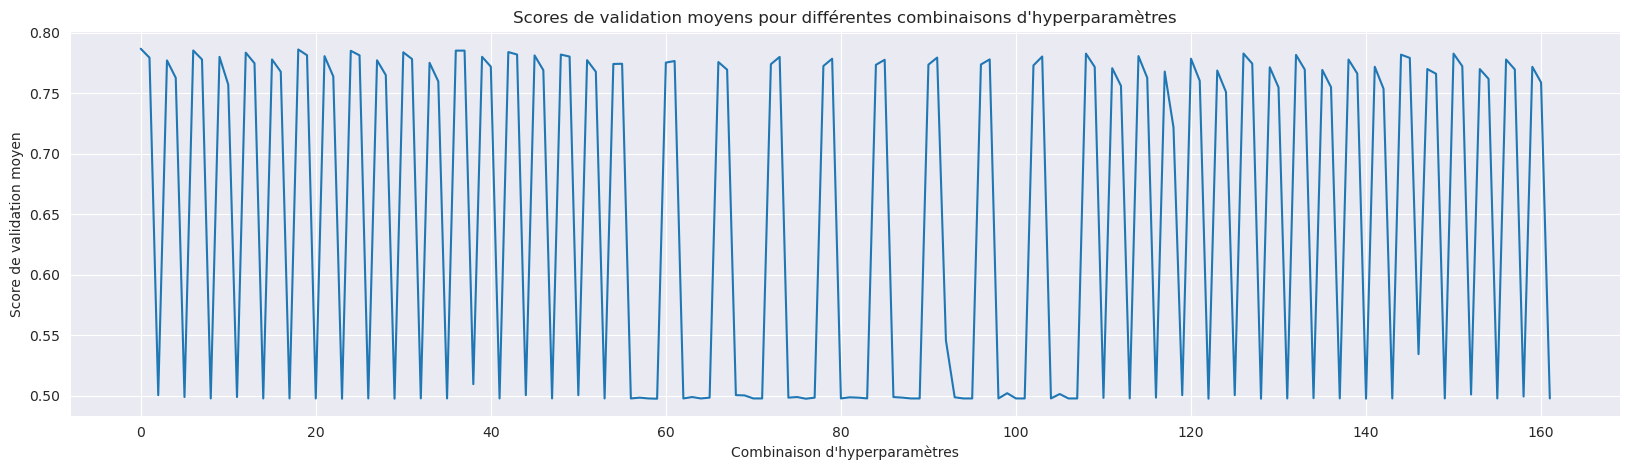

In [37]:
# Récupération des résultats de la recherche sur la grille
results = grid_search.cv_results_

# Extrait les scores de validation moyens et les hyperparamètres correspondants
mean_val_scores = results['mean_test_score']
params = results['params']

# Tracé des scores de validation moyens en fonction des hyperparamètres
for i, param in enumerate(params):
    print(param, mean_val_scores[i])

# Exemple de tracé (à personnaliser en fonction de vos besoins)
plt.figure(figsize=(20,5))
plt.plot(mean_val_scores)
plt.xlabel('Combinaison d\'hyperparamètres')
plt.ylabel('Score de validation moyen')
plt.title('Scores de validation moyens pour différentes combinaisons d\'hyperparamètres')
plt.show()

In [38]:
import joblib
joblib.dump(results, 'grid_search_results_for_best_model_in_deep_learning_change_layers.pkl')

['grid_search_results_for_best_model_in_deep_learning_change_layers.pkl']